In [1]:
import os
import time
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

#preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
#model
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from google.cloud import storage
pio.renderers.default = 'notebook'

In [2]:
def read_data_from_gcs(bucket_name, folder, filename, delimiter=','):
    start_time = time.time()  # Start measuring time
    blob = storage_client.get_bucket(bucket_name).blob(f'{folder}/{filename}')
    csv_data = blob.download_as_text()
    df = pd.read_csv(StringIO(csv_data), delimiter=delimiter)
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Read {filename} complete. Elapsed time: {elapsed_time:.2f} seconds")
    return df

def remove_lawyers(df, lawyer_ids):
    filtered_df = df[~df['lawyer_id'].isin(lawyer_ids)]
    return filtered_df

In [3]:
# Set path
relative_path = '../../deep-flash-sa.json'
file_path = os.path.abspath(relative_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = file_path
storage_client = storage.Client()

In [4]:
df_consultations = read_data_from_gcs('perqara-dendrobium', 'raw/postgres/csv/consultations', 'consultations.csv', delimiter='|')

Read consultations.csv complete. Elapsed time: 3.18 seconds


In [5]:
#remove testing user
df_consultations = remove_lawyers(df_consultations, [36, 38, 48, 120, 192, 195])
df_consultations = df_consultations[df_consultations['status'] == 600]
df_consultations['created_at'] = pd.to_datetime(df_consultations['created_at'])

count = df_consultations['created_at'].to_frame().reset_index(drop=True)
# Set 'timestamp' as the DataFrame index
count.set_index('created_at', inplace=True)
# Resample the data to daily count and reset the index
df_daily_count = count.resample('D').size().reset_index()
# Rename the columns
df_daily_count.rename(columns={'created_at': 'date', 0: 'count'}, inplace=True)

In [6]:
df_daily_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    171 non-null    datetime64[ns]
 1   count   171 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [7]:
start = df_daily_count['date'].dt.strftime('%Y%m%d').min()
end = df_daily_count['date'].dt.strftime('%Y%m%d').max()

df_daily_count.to_csv(f'../data/raw/{start}-to-{end}.csv', index=False)

### Pre-processing

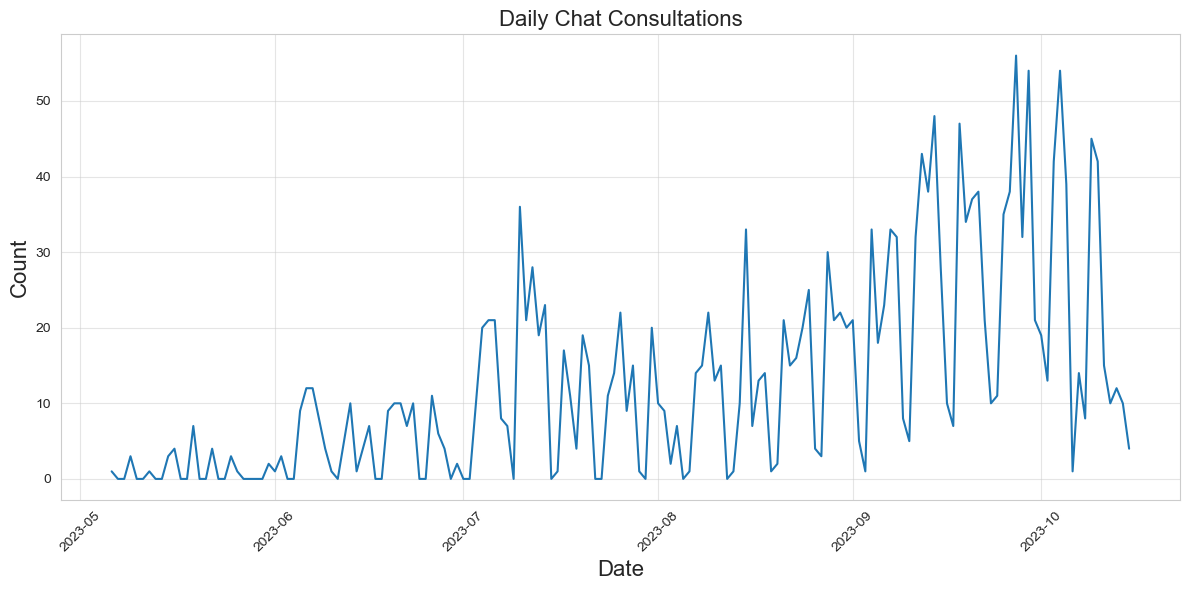

In [54]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(data=df_daily_count, x='date', y='count')

# Customize the plot
plt.title('Daily Chat Consultations', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

In [129]:
# Function to create lagged features for time series data
def create_lagged_features(data, lag):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'Lag_{i}'] = data['count'].shift(i)
    return lagged_data

def data_process_stats(df, train_index, test_index):
    time_series = df['count']
    train_data, test_data = time_series[train_index], time_series[test_index]
    return train_data, test_data

def data_process_ml(df, train_index, test_index):
    
    df = df.set_index('date', inplace=False)

    lag = 7  # Number of lagged values, adjust as needed
    # Apply the function to create lagged features
    lagged_df = create_lagged_features(df, lag)
    
    X = lagged_df.drop(['count'], axis=1)
    y = lagged_df['count']
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    
    return X_train, y_train, X_test, y_test
    
def data_process_prophet(df, train_index, test_index):
    df = df.rename(columns={'date': 'ds', 'count': 'y'}, inplace=False)
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    return train_data, test_data

# Model model
def model_exponential_smoothing(train_data, test_data):
    model = ExponentialSmoothing(train_data, seasonal="add", seasonal_periods=7)
    fit = model.fit()
    y_pred = fit.forecast(steps=len(test_data)) 
    return y_pred

def model_auto_arima(train_data, test_data):
    auto_model = auto_arima(train_data, seasonal=True, m=7, trace=True)
    n_forecast = len(test_data)
    y_pred, conf_int = auto_model.predict(n_forecast, return_conf_int=True)
    return y_pred

def model_linear_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_lgb(X_train, y_train, X_test):
    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_xgboost(X_train, y_train, X_test):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def model_prophet(train_data_pr, test_data_pr):
    model = Prophet()
    model.fit(train_data_pr)
    y_pred = model.predict(test_data_pr)
    return y_pred['yhat']

def produce_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return [mae, rmse, mape]


In [9]:
df = df_daily_count.copy()

In [13]:
test_data = create_lagged_features(df, 7)
test_data

,date,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2023-05-06,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-07,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-05-08,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,2023-05-09,3,0.0,0.0,1.0,NaN,NaN,NaN,NaN
4,2023-05-10,0,3.0,0.0,0.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
155,2023-10-08,8,14.0,1.0,39.0,54.0,42.0,13.0,19.0
156,2023-10-09,45,8.0,14.0,1.0,39.0,54.0,42.0,13.0
157,2023-10-10,42,45.0,8.0,14.0,1.0,39.0,54.0,42.0
158,2023-10-11,15,42.0,45.0,8.0,14.0,1.0,39.0,54.0


In [15]:
test_data.fillna(test_data.mean())


/var/folders/fh/5kqpbzgx5cgdq_m9npj98tfh0000gn/T/ipykernel_13973/2506738743.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,date,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2023-05-06,1,12.861635,12.848101,12.66242,12.455128,12.483871,12.474026,12.54902
1,2023-05-07,0,1.000000,12.848101,12.66242,12.455128,12.483871,12.474026,12.54902
2,2023-05-08,0,0.000000,1.000000,12.66242,12.455128,12.483871,12.474026,12.54902
3,2023-05-09,3,0.000000,0.000000,1.00000,12.455128,12.483871,12.474026,12.54902
4,2023-05-10,0,3.000000,0.000000,0.00000,1.000000,12.483871,12.474026,12.54902
...,...,...,...,...,...,...,...,...,...
155,2023-10-08,8,14.000000,1.000000,39.00000,54.000000,42.000000,13.000000,19.00000
156,2023-10-09,45,8.000000,14.000000,1.00000,39.000000,54.000000,42.000000,13.00000
157,2023-10-10,42,45.000000,8.000000,14.00000,1.000000,39.000000,54.000000,42.00000
158,2023-10-11,15,42.000000,45.000000,8.00000,14.000000,1.000000,39.000000,54.00000


In [11]:
create_lagged_features

<function __main__.create_lagged_features(data, lag)>

In [76]:
pwd!

'/Users/fadilrisdian/perqara-projects/3. daily-chat-forecaster/notebooks'

In [89]:
model_linear_regression(X_train, y_train, X_test)

ValueError: could not convert string to float: '2023-05-06'

In [150]:
n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

models = ['es', 'arima', 'lr', 'lgb', 'xgb', 'pr']

metric_results = []

for model in models:
    if model == 'es' or model == 'arima':
        df = pd.read_csv('../data/processed/data_stats.csv')
        
    if model == 'lr' or model == 'lgb' or model == 'xgb':
        df = pd.read_csv('../data/processed/data_ml.csv')

    if model == 'pr':
        df = pd.read_csv('../data/processed/data_pr.csv')

    # Initialize a list to store the mean squared errors for each fold
    scores = [] 
    
    path = '/Users/fadilrisdian/perqara-projects/3. daily-chat-forecaster/data/processed/'

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        print(f"Fold {i}:")
        print(train_index)
        print(test_index)

        if model == 'es' or model == 'arima':
            df = pd.read_csv(path + 'data_stats.csv')
            train_data, y_test = df.iloc[train_index], df.iloc[test_index]
            if model == 'es':
                y_pred = model_exponential_smoothing(train_data, y_test)
            if model == 'arima':
                y_pred = model_auto_arima(train_data, y_test)
                
        if model == 'lr' or model == 'lgb' or model == 'xgb':
            df = pd.read_csv(path + 'data_ml.csv')
            df = df.drop(['date'], axis=1)
            X = df.drop(['count'], axis=1)
            y = df['count']

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            if model == 'lr':
                y_pred = model_linear_regression(X_train, y_train, X_test)
            if model == 'lgb':
                y_pred = model_lgb(X_train, y_train, X_test)
            if model == 'xgb':
                y_pred = model_xgboost(X_train, y_train, X_test)

        if model == 'pr':
            df = pd.read_csv(path + 'data_pr.csv')
            train_data_pr, y_test = df.iloc[train_index], df.iloc[test_index]
            y_pred = model_prophet(train_data_pr, y_test)
            y_test = y_test['y']


        # Calculate the MAE, RMSE, MAPE
        metrics = produce_metrics(y_test, y_pred)

        # Append metrics score
        scores.append(metrics)
        
        #Print RMSE for each fold
        print(f"Fold RMSE {model}: {metrics}")
        
        avg_scores = metrics_results(scores)
        
    metric_results.append(avg_scores)


Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55]
Fold RMSE es: [4.392310926125278, 5.745301750948286, 242509863088787.0]
Fold 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
[56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81]
Fold RMSE es: [11.350637519452224, 14.242364869499212, 1823601611802317.5]
Fold 2:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81]
[ 82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107]
Fold RMSE es: [4.36119574711991, 5.767378416

 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=559.735, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=536.280, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=540.280, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=557.832, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=555.340, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=533.508, Time=0.05 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=531.597, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=529.752, Time=0.05 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=544.382, Time=0.04 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=531.481, Time=0.10 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=540.487, Time=0.09 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=544.696, Time=0.05 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=531.602, Time=0.05 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=700.458, Time=0.18 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=701.733, Time=0.34 sec
 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,1)(1,0,1)[7]             : AIC=694.358, Time=0.11 sec
 ARIMA(2,1,1)(0,0,1)[7]             : AIC=724.605, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[7]             : AIC=713.983, Time=0.06 sec
 ARIMA(2,1,1)(2,0,1)[7]             : AIC=695.330, Time=0.20 sec
 ARIMA(2,1,1)(1,0,2)[7]             : AIC=695.095, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[7]             : AIC=733.078, Time=0.04 sec
 ARIMA(2,1,1)(0,0,2)[7]             : AIC=717.464, Time=0.27 sec
 ARIMA(2,1,1)(2,0,0)[7]             : AIC=702.341, Time=0.24 sec
 ARIMA(2,1,1)(2,0,2)[7]             : AIC=inf, Time=0.46 sec
 ARIMA(1,1,1)(1,0,1)[7]             : AIC=699

Fold RMSE lgb: [4.970954664293776, 7.006599301954851, 1253802739682418.8]
Fold 3:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
[108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133]
Fold RMSE lgb: [8.974852164642623, 12.173743539661897, 0.7395161259815926]
Fold 4:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  

17:23:41 - cmdstanpy - INFO - Chain [1] start processing


Fold RMSE xgb: [9.91211753567824, 13.014327996085061, 1992593171243638.8]
Fold 2:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81]
[ 82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107]
Fold RMSE xgb: [6.000743384544666, 9.408497008924472, 413577195855243.75]
Fold 3:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
[108 109 110 111 112 113 114 115 116 11

17:23:41 - cmdstanpy - INFO - Chain [1] done processing
17:23:42 - cmdstanpy - INFO - Chain [1] start processing
17:23:42 - cmdstanpy - INFO - Chain [1] done processing
17:23:42 - cmdstanpy - INFO - Chain [1] start processing
17:23:42 - cmdstanpy - INFO - Chain [1] done processing
17:23:42 - cmdstanpy - INFO - Chain [1] start processing


Fold RMSE pr: [4.5031119229708105, 5.869498228902518, 230804187538652.0]
Fold 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
[56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81]
Fold RMSE pr: [8.122883847963259, 10.485846283482342, 4196749599367595.0]
Fold 2:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81]
[ 82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107]
Fold RMSE pr: [7.21199385789923, 8.140386338164918, 5079623043439798.0]
Fold 3:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35


17:23:42 - cmdstanpy - INFO - Chain [1] done processing
17:23:42 - cmdstanpy - INFO - Chain [1] start processing
17:23:42 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE pr: [8.312053224083588, 11.00521646239914, 0.699487302850357]
Fold 4:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133]
[134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159]
Fold RMSE pr: [12.753582574877306, 15.177193127472691, 1.4219155344439574]


In [157]:
df_date['date'] = pd.to_datetime(df_date['date'])

In [161]:
df_date.dtypes

date    datetime64[ns]
dtype: object

In [163]:
df_date = pd.read_csv(path+'date.csv')
df_date['date'] = pd.to_datetime(df_date['date'])
start = df_date['date'].dt.strftime('%Y%m%d').min()
end = df_date['date'].dt.strftime('%Y%m%d').max()

df_final_scores.to_csv(f'/Users/fadilrisdian/perqara-projects/3. daily-chat-forecaster/reports/ml_scores-{start}-{end}.csv', index=False)

In [152]:
# Create a Pandas DataFrame
df_model = pd.DataFrame({'Model': ['Exponential Smoothing', 'ARIMA', 'Linear Regression', 'LightGBM', 'XGBoost','Prophet']})
df_res = pd.DataFrame(metric_results)
df_res.columns = ['MAE', 'RMSE', 'MAPE']
df_final_scores = pd.concat([df_model, df_res], axis=1)

In [153]:
df_final_scores

,Model,MAE,RMSE,MAPE
0,Exponential Smoothing,7.937264,10.400986,7.030432e+14
1,ARIMA,8.010439,10.313850,1.512473e+15
2,Linear Regression,7.946187,10.580718,1.237170e+15
3,LightGBM,8.379614,10.720419,1.066677e+15
4,XGBoost,8.380818,11.200779,6.229940e+14
5,Prophet,8.180725,10.135628,1.901435e+15


In [23]:
n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize a list to store the mean squared errors for each fold
scores_es = []
scores_arima = []
scores_lr = []
scores_lgb = []
scores_xgb = []
scores_pr = []

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(train_index)
    print(test_index)
    #stats model
    train_data, test_data = data_process_stats(df, train_index, test_index)
    y_pred_es = model_exponential_smoothing(train_data, test_data)
    
    if i > 1: #auto ARIMA can't fit with small data
        y_pred_arima = model_auto_arima(train_data, test_data)
        metrics_arima = produce_metrics(y_test, y_pred_arima)
        scores_arima.append(metrics_arima)
    
    #ML model
    X_train, y_train, X_test, y_test = data_process_ml(df, train_index, test_index)
    y_pred_lr = model_linear_regression(X_train, y_train, X_test)
    y_pred_lgb = model_lgb(X_train, y_train, X_test)
    y_pred_xgb = model_xgboost(X_train, y_train, X_test)
    
    #Prophet model
    train_data_pr, test_data_pr = data_process_prophet(df, train_index, test_index)
    y_pred_pr = model_prophet(train_data_pr, test_data_pr)
    
    # Calculate the Mean Squared Error (MSE) for this fold
    metrics_es = produce_metrics(y_test, y_pred_es)
    metrics_lr = produce_metrics(y_test, y_pred_lr)
    metrics_lgb = produce_metrics(y_test, y_pred_lgb)
    metrics_xgb = produce_metrics(y_test, y_pred_xgb)
    metrics_pr = produce_metrics(y_test, y_pred_pr)
    
    #append mterics score
    scores_es.append(metrics_es)     
    scores_lr.append(metrics_lr)
    scores_lgb.append(metrics_lgb)
    scores_xgb.append(metrics_xgb)
    scores_pr.append(metrics_pr)
    
    #Print RMSE for each fold
    print(f"Fold RMSE es: {metrics_es}")
    if i > 1: #auto ARIMA can't fit with small data
        print(f"Fold RMSE arima: {metrics_arima}")
    print(f"Fold RMSE lr: {metrics_lr}")
    print(f"Fold RMSE lgb: {metrics_lgb}")
    print(f"Fold RMSE xgb: {metrics_xgb}")
    print(f"Fold RMSE prophet: {metrics_pr}")
    print("----------")
    
print("Metrics es:", scores_es)
print("Metrics arima:", scores_arima)
print("Metrics lr:", scores_lr)
print("Metrics lgb:", scores_lgb)
print("Metrics xgb:", scores_xgb)
print("Metrics prophet:", scores_pr)

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearRegression was fitted without feature names

13:50:42 - cmdstanpy - INFO - Chain [1] start processing


Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
[28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52]


13:50:43 - cmdstanpy - INFO - Chain [1] done processing
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearRegression was fitted without feature names

13:50:43 - cmdstanpy - INFO - Chain [1] start processing
13:50:43 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [4.3600000665308976, 5.8103356951708705, 135108107771777.95]
Fold RMSE lr: [5.460327357776425, 6.905205036379692, 1424827176595289.0]
Fold RMSE lgb: [4.949999999999999, 6.138906536948396, 1486187877032264.2]
Fold RMSE xgb: [4.877577365934849, 6.0557486319938665, 5069063658689004.0]
Fold RMSE prophet: [4.4837824096777545, 5.933500662163001, 163443279623405.88]
----------
Fold 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
[53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76
 77]
Fold RMSE es: [8.2894612275326, 11.049911060425677, 3034054971622503.0]
Fold RMSE lr: [7.865452531257026, 11.158238476670984, 6448281087879098.0]
Fold RMSE lgb: [9.340655365272927, 12.318914281628878, 4076742118699144.5]
Fold RMSE xgb: [9.442923269271851, 11.462191320601642, 6558910442519921.0]
Fold RMSE prophet: [7.711236057365514, 9.735871476679387, 5650738783

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearRegression was fitted without feature names

13:51:01 - cmdstanpy - INFO - Chain [1] start processing
13:51:01 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [4.711074414498454, 6.289149793628198, 1581862523243719.2]
Fold RMSE arima: [10.595452986511939, 12.721025742942286, 1.5709729589899082e+16]
Fold RMSE lr: [6.758587235646299, 8.566920211580808, 2582899745549324.5]
Fold RMSE lgb: [5.375255285709098, 7.112701398884573, 3094104232174316.0]
Fold RMSE xgb: [6.484646795988083, 9.491475562348946, 795264965316445.9]
Fold RMSE prophet: [7.484315415560266, 8.318399824330921, 7038703753006785.0]
----------
Fold 3:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]
[103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127]
Perfor

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearRegression was fitted without feature names

13:51:17 - cmdstanpy - INFO - Chain [1] start processing
13:51:17 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [6.128708807580307, 8.662931719170821, 0.45879303544126576]
Fold RMSE arima: [9.747218010982305, 11.799564782958491, 9737279196363326.0]
Fold RMSE lr: [6.246652420027264, 8.005008867473279, 1.0983963037536006]
Fold RMSE lgb: [5.768699632824478, 7.621504876169034, 0.7309836626116684]
Fold RMSE xgb: [5.0600619065761565, 7.275212792324976, 0.375994278368304]
Fold RMSE prophet: [5.6505971200149565, 7.163817235217512, 0.9802658921354894]
----------
Fold 4:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
[128 129 

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LinearRegression was fitted without feature names

13:51:34 - cmdstanpy - INFO - Chain [1] start processing
13:51:34 - cmdstanpy - INFO - Chain [1] done processing


Fold RMSE es: [12.200008867510565, 15.066391030094781, 0.3665343132507253]
Fold RMSE arima: [11.596030045096409, 13.476394066252503, 3.3806275000465145]
Fold RMSE lr: [8.93457655938917, 11.573243355771277, 0.2869413547258426]
Fold RMSE lgb: [13.927732277355728, 16.716529849960263, 0.43295681797386626]
Fold RMSE xgb: [16.443439407348635, 19.39819339403099, 0.5381520504927724]
Fold RMSE prophet: [14.076241133824363, 17.076118505963382, 0.39919118068545534]
----------
Metrics es: [[4.3600000665308976, 5.8103356951708705, 135108107771777.95], [8.2894612275326, 11.049911060425677, 3034054971622503.0], [4.711074414498454, 6.289149793628198, 1581862523243719.2], [6.128708807580307, 8.662931719170821, 0.45879303544126576], [12.200008867510565, 15.066391030094781, 0.3665343132507253]]
Metrics arima: [[10.595452986511939, 12.721025742942286, 1.5709729589899082e+16], [9.747218010982305, 11.799564782958491, 9737279196363326.0], [11.596030045096409, 13.476394066252503, 3.3806275000465145]]
Metrics 

In [143]:
def metrics_results(model_score):
    num_rows = len(model_score)
    # Initialize a list to store the column sums
    column_sums = []

    # Calculate the sum of each column
    for col in range(len(model_score[0])):
        col_sum = sum(row[col] for row in model_score)
        column_sums.append(col_sum / num_rows)

    return column_sums

In [142]:
def metrics_results(model_score):
    num_rows = len(model_score)
    # Initialize a list to store the column sums
    column_sums = []

    # Calculate the sum of each column
    for col in range(len(model_score[0])):
        col_sum = sum(row[col] for row in model_score)
        column_sums.append(col_sum / num_rows)

    return column_sums

avg_es = metrics_results(scores_es)
avg_arima = metrics_results(scores_arima)
avg_lr = metrics_results(scores_lr)
avg_lgb = metrics_results(scores_lgb)
avg_sgb = metrics_results(scores_xgb)
avg_pr = metrics_results(scores_pr)

# Create a Pandas DataFrame
df_model = pd.DataFrame({'Model': ['Exponential Smoothing', 'ARIMA', 'Linear Regression', 'LightGBM', 'XGBoost','Prophet']})
df_res = pd.DataFrame([avg_es, avg_arima, avg_lr, avg_lgb, avg_sgb, avg_pr])
df_res.columns = ['MAE', 'RMSE', 'MAPE']
df_final_scores = pd.concat([df_model, df_res], axis=1)

NameError: name 'scores_es' is not defined

In [14]:
# Highlight the highest value in each numeric column
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

# Select only the numeric columns for highlighting
numeric_cols = ['MAE', 'RMSE', 'MAPE']
highlighted_metrics_df = df_final_scores.style.apply(highlight_min, subset=numeric_cols, axis=0)

# Display the highlighted DataFrame
highlighted_metrics_df

,Model,MAE,RMSE,MAPE
0,Exponential Smoothing,7.137851,9.375744,950205120527600.000000
1,ARIMA,10.646234,12.665662,8482336262087471.000000
2,Linear Regression,7.053119,9.241723,2091201602004742.750000
3,LightGBM,7.872469,9.981711,1731406845581145.250000
4,XGBoost,8.461730,10.736564,2484647813305074.000000
5,Prophet,7.881234,9.645542,2570577163273943.000000


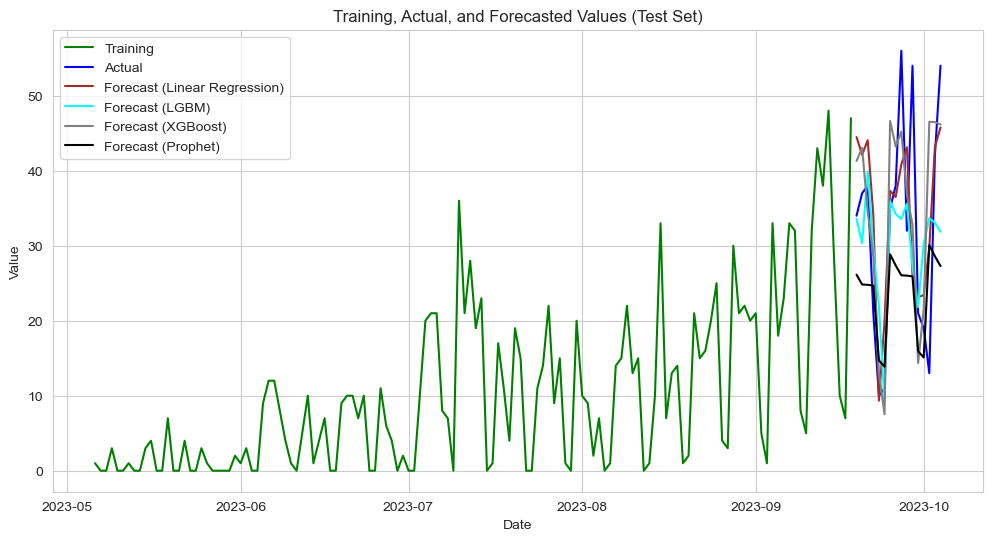

In [268]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(df_daily_count['date'][:train_size], train_data, label='Training', color='green')
plt.plot(test_dates, test_data, label='Actual', color='blue')
# plt.plot(test_dates, forecast_es, label='Forecast (Exponential Smoothing)', color='red')
# plt.plot(test_dates, forecast_arima, label='Forecast (ARIMA)', color='purple')
plt.plot(test_dates, forecast_lr, label='Forecast (Linear Regression)', color='brown')
plt.plot(test_dates, forecast_lgb, label='Forecast (LGBM)', color='cyan')
plt.plot(test_dates, forecast_xgb, label='Forecast (XGBoost)', color='gray')
plt.plot(test_dates, forecast_prophet['yhat'], label='Forecast (Prophet)', color='black')

plt.legend()
plt.title('Training, Actual, and Forecasted Values (Test Set)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## Forecast Future using linear regression

In [383]:
# Create and fit a Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
forecast_lr = model_lr.predict(X_test)### Linear regression 

alpha = 0.15
residuals = y_test - y_pred
mse = np.mean(residuals ** 2)
prediction_std = np.sqrt(mse)

n = len(X_test)
t_score = np.abs(np.percentile(np.random.standard_t(df=n-2, size=10000), 100 * (1 - alpha / 2)))

# Calculate the prediction interval for each data point
prediction_interval_lower = y_pred - t_score * prediction_std
prediction_interval_upper = y_pred + t_score * prediction_std

In [384]:
# Define the number of days to forecast
forecast_horizon = 88

# Create a copy of the lagged DataFrame to generate forecasts
forecast_data = lagged_df.copy()

start_date = forecast_data.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["Forecasted_Value"])
forecast_df

forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = forecast_data.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    predicted_result = model_lr.predict(latest_data_row)
    predicted_result = np.round(predicted_result).astype(int)
    last_index = len(latest_data_row) - 1
    new_data_row = np.concatenate((predicted_result, latest_data_row[0]))
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-1].reshape(1, -1)

forecast_value = [array[0] for array in forecast_array]

forecast_df["Forecasted_Value"] = forecast_value

In [385]:
# Calculate the prediction interval for each data point
prediction_interval_lower = y_pred - t_score * prediction_std
prediction_interval_upper = y_pred + t_score * prediction_std

forecast_df['lower'] = forecast_df["Forecasted_Value"] - t_score * prediction_std
forecast_df['upper'] = forecast_df["Forecasted_Value"] + t_score * prediction_std


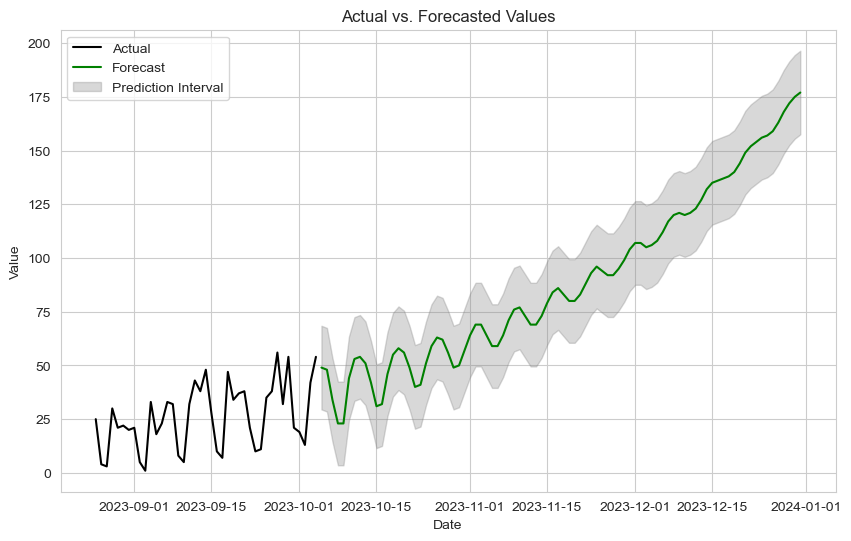

In [403]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(df_daily_count['date'][-41:], df_daily_count['count'][-41:], label='Actual', color='black')
plt.plot(forecast_df.index, forecast_df['Forecasted_Value'], label='Forecast', color='green')
# Add prediction intervals
plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='gray', alpha=0.3, label='Prediction Interval')


plt.title('Actual vs. Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [387]:
forecast_df.sum()

Forecasted_Value    7898.000000
lower               6185.237725
upper               9610.762275
dtype: float64

In [391]:
forecast_df_reset = forecast_df.reset_index()
forecast_df_reset.rename(columns = {'index':'date'}, inplace = True)
forecast_df_reset['month'] = forecast_df_reset['date'].dt.month

In [396]:
forecast_df_reset.groupby('month')[['Forecasted_Value', 'lower', 'upper']].sum().sum()

Forecasted_Value    7898.000000
lower               6185.237725
upper               9610.762275
dtype: float64

## Forecast Future using prophet

In [333]:
df_prophet = df_daily_count.copy()
df_prophet.sort_values(by='date', inplace=True)
df_prophet.rename(columns={'date': 'ds', 'count': 'y'}, inplace=True)

model = Prophet()
model.fit(df_prophet)
future_dates = model.make_future_dataframe(periods=89)

14:14:24 - cmdstanpy - INFO - Chain [1] start processing
14:14:24 - cmdstanpy - INFO - Chain [1] done processing


In [338]:
forecast = model.predict(future_dates)
forecast_result = forecast[forecast['ds'] >= '2023-10-04'][['ds','yhat', 'yhat_lower', 'yhat_upper']]
forecast_result

,ds,yhat,yhat_lower,yhat_upper
151,2023-10-04,34.332932,24.552608,44.186811
152,2023-10-05,32.306471,22.546936,42.452638
153,2023-10-06,32.503814,22.704320,42.419221
154,2023-10-07,21.447104,12.770518,31.966519
155,2023-10-08,20.684217,10.832745,30.771182
...,...,...,...,...
236,2023-12-28,54.285803,44.546930,64.791077
237,2023-12-29,54.483146,44.787294,63.999574
238,2023-12-30,43.426436,33.819824,53.158053
239,2023-12-31,42.663549,32.255767,51.798228


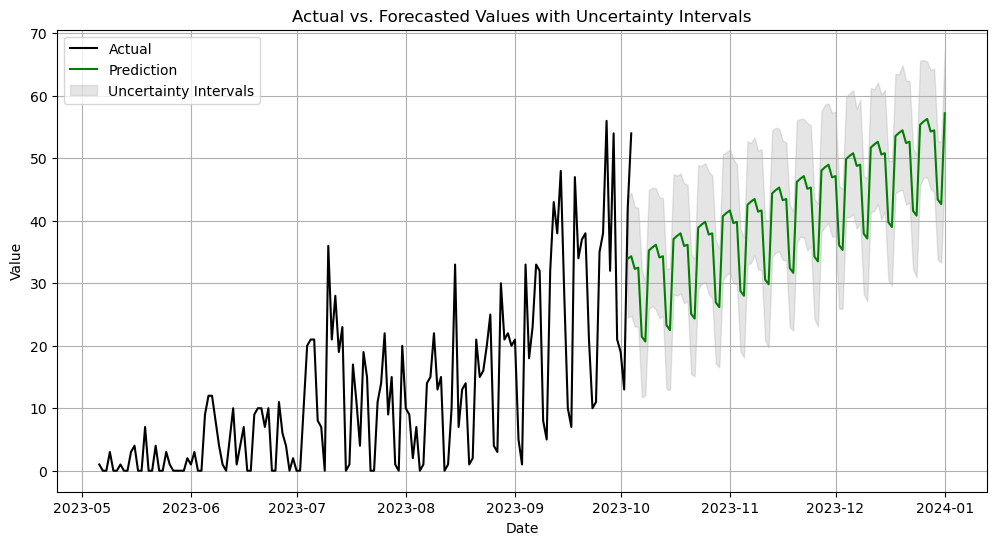

In [24]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(df_daily_count['date'], df_daily_count['count'], label='Actual', color='black')
plt.plot(forecast_result['ds'], forecast_result['yhat'], label='Prediction', color='green')
plt.fill_between(forecast_result['ds'], forecast_result['yhat_lower'], forecast_result['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Intervals')

plt.title('Actual vs. Forecasted Values with Uncertainty Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [25]:
forecast_result['month'] = forecast_result['ds'].dt.month

In [66]:
forecast_result.groupby('month')['yhat'].sum().sum() + 1881

5616.637939961658

In [27]:
forecast_result.groupby('month')['yhat_lower'].sum().sum()

2857.6671105103505

In [28]:
forecast_result.groupby('month')['yhat_upper'].sum().sum()

4622.7952867587355

In [29]:
df_daily_count['count'].sum()

1881

In [30]:
df_coba = df_daily_count.copy()
df_coba['month'] = df_coba['date'].dt.month
df_coba.groupby('month')['count'].sum()

month
5      29
6     146
7     373
8     386
9     819
10    128
Name: count, dtype: int64